In [1]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds

## Downloading and preprocessing the data

In [2]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [3]:
# Downloading the MNIST dataset

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [4]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [5]:
# Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [6]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [7]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [8]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [9]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [10]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [11]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

## Creating the model and training it

In [12]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [13]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

In [14]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 24, 24, 50)            1300        
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 12, 12, 50)            0           
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 10, 50)            22550       
___________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 5, 5, 50)              0           
___________________________________________________________________________
flatten (Flatten)                (None, 1250)                  0           
___________________________________________________________________________
dense (Dense)                    (None, 10)                    12510

In [15]:
# Defining the loss function

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [17]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [18]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 1
)

Epoch 1/20


2021-11-09 11:48:59.416447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


422/422 [==============================] - 31s 67ms/step - loss: 0.2622 - accuracy: 0.9280 - val_loss: 0.0802 - val_accuracy: 0.9772
Epoch 2/20
422/422 [==============================] - 30s 68ms/step - loss: 0.0689 - accuracy: 0.9798 - val_loss: 0.0599 - val_accuracy: 0.9810
Epoch 3/20
422/422 [==============================] - 32s 72ms/step - loss: 0.0517 - accuracy: 0.9847 - val_loss: 0.0468 - val_accuracy: 0.9870
Epoch 4/20
422/422 [==============================] - 32s 73ms/step - loss: 0.0431 - accuracy: 0.9867 - val_loss: 0.0322 - val_accuracy: 0.9908
Epoch 5/20
422/422 [==============================] - 32s 73ms/step - loss: 0.0360 - accuracy: 0.9888 - val_loss: 0.0321 - val_accuracy: 0.9907
Epoch 6/20
422/422 [==============================] - 32s 74ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0195 - val_accuracy: 0.9938
Epoch 7/20
422/422 [==============================] - 33s 75ms/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.0205 - val_accuracy: 0.9933
Epo

## Testing our model

In [19]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.0272 - accuracy: 0.9925


In [20]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0272. Test accuracy: 99.25%


### Plotting images and the results

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

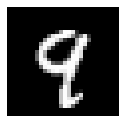

Label: 9


In [23]:
# The image to be displayed and tested
i = 600


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

<BarContainer object of 10 artists>

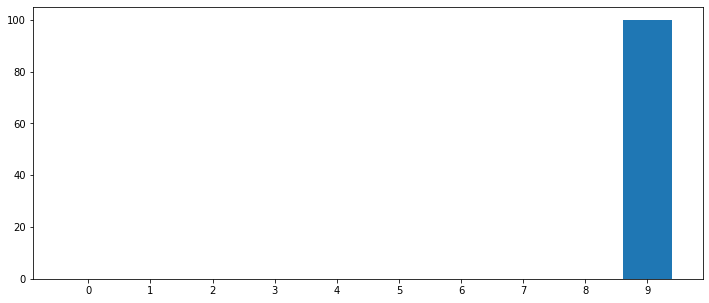

In [24]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities 
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

As we can see, the model correctly predicts the image to be a 9; and it actually is.